In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

random_state = 42

In [2]:
df = pd.read_csv(
    "data/train.csv", usecols=["id", "genome_sequence", "species"]
)  # Removes the index column of the csv
print("Shape of the dataset: ", df.shape)

Shape of the dataset:  (19800000, 3)


In [3]:
df.head()

,id,genome_sequence,species
0,11408003,ccacatcccctccagcacctgttgtttcctgactttttaatgattg...,Gorilla_gorilla
1,18639873,tgtttacttgccaatctttgtttagctgtcagagtggcttgctaaa...,Gorilla_gorilla
2,9869298,tctgtgaagaaagacattggtagcttgatggggatgacattgaatc...,Homo_sapiens
3,10762804,ttgtgagaattacgtgagatgatagatttagggactatagaatagt...,Gorilla_gorilla
4,13724428,gcaaaaaataagttgataagttgattgatatgttattagcttaatt...,Gorilla_gorilla


In [4]:
# Check that there are no missing values
df.isnull().sum()

id                 0
genome_sequence    0
species            0
dtype: int64

In [5]:
# Check the balancing of the target
df.species.value_counts()

species
Homo_sapiens       9900585
Gorilla_gorilla    9899415
Name: count, dtype: int64

In [6]:
# Get the average length of the genome sequences
df.genome_sequence.apply(lambda x: len(x)).value_counts()

genome_sequence
80    19799984
37           2
39           1
2            1
30           1
25           1
16           1
3            1
15           1
57           1
48           1
32           1
31           1
43           1
60           1
50           1
Name: count, dtype: int64

Let's remove the few that aren't of the 80 long

In [7]:
# Remove the <20 genome sequences that are not 80 long
df = df[df.genome_sequence.apply(lambda x: len(x)) == 80]
df.shape

(19799984, 3)

## Data Preparation

In [8]:
# Create a label column that change the species name into a number
labels_dict = {species: i for i, species in enumerate(df.species.unique())}
df["label"] = df.species.map(labels_dict)
df.head()

,id,genome_sequence,species,label
0,11408003,ccacatcccctccagcacctgttgtttcctgactttttaatgattg...,Gorilla_gorilla,0
1,18639873,tgtttacttgccaatctttgtttagctgtcagagtggcttgctaaa...,Gorilla_gorilla,0
2,9869298,tctgtgaagaaagacattggtagcttgatggggatgacattgaatc...,Homo_sapiens,1
3,10762804,ttgtgagaattacgtgagatgatagatttagggactatagaatagt...,Gorilla_gorilla,0
4,13724428,gcaaaaaataagttgataagttgattgatatgttattagcttaatt...,Gorilla_gorilla,0


In [9]:
# Define a function to one hot encode a DNA sequence
def one_hot_encote_dna(seq):
    return np.array(
        [
            [
                1 if c == "A" else 0,
                1 if c == "C" else 0,
                1 if c == "G" else 0,
                1 if c == "T" else 0,
            ]
            for c in seq.upper()
        ]
    )

In [10]:
# Drop unnecessary columns
df = df.drop(columns=["id", "species"])
df.head()

,genome_sequence,label
0,ccacatcccctccagcacctgttgtttcctgactttttaatgattg...,0
1,tgtttacttgccaatctttgtttagctgtcagagtggcttgctaaa...,0
2,tctgtgaagaaagacattggtagcttgatggggatgacattgaatc...,1
3,ttgtgagaattacgtgagatgatagatttagggactatagaatagt...,0
4,gcaaaaaataagttgataagttgattgatatgttattagcttaatt...,0


In [11]:
# Split the dataset into train and test
df_train, df_test = train_test_split(
    df.sample(n=500000, random_state=random_state),
    test_size=0.2,
    random_state=random_state,
)
print("Shape of the train dataset: ", df_train.shape)
print("Shape of the test dataset: ", df_test.shape)

Shape of the train dataset:  (800000, 2)
Shape of the test dataset:  (200000, 2)


# Feed Forward Neural Network


In [12]:
import torch

In [13]:
def encode_vector(seq):
    return one_hot_encote_dna(seq)

In [14]:
# Create a custom dataset
class GenomeDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return encode_vector(row.genome_sequence), row.label

In [15]:
# Create datasets for df_train and test and dataloaders
train_dataset = GenomeDataset(df_train)
test_dataset = GenomeDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [16]:
# Create Deep neural network of input size 320 and output size 1
import torch.nn as nn
import torch.nn.functional as F


class GenomeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(4, 4)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(80 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embed(x)
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, 0.05)
        x = F.relu(self.fc2(x))
        # x = F.dropout(x, 0.05)
        x = F.relu(self.fc3(x))
        # x = F.dropout(x, 0.05)
        x = self.out(x)
        return x

In [17]:
from tqdm import tqdm

clf = GenomeClassifier()

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_args = {"lr": 0.01, "weight_decay": 1e-5}
optimizer = torch.optim.Adam(clf.parameters(), **optimizer_args)


# Define a function to train the model
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        outputs = model(inputs.long())
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [73]:
# Train

for epoch in range(5):
    train_loss = train(clf, train_dataloader, criterion, optimizer)
    print(f"Epoch {epoch + 1} | Train loss: {train_loss:.3f}")
    # Conpute accuracy
    clf.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_dataloader:
            outputs = clf(inputs.long())
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
        print(f"Accuracy: {correct / total:.3f}")

100%|██████████| 6250/6250 [03:57<00:00, 26.30it/s]


Epoch 1 | Train loss: 0.694
Accuracy: 0.499


100%|██████████| 6250/6250 [11:54<00:00,  8.75it/s]


Epoch 2 | Train loss: 0.693
Accuracy: 0.501


100%|██████████| 6250/6250 [13:36<00:00,  7.66it/s]


Epoch 3 | Train loss: 0.693
Accuracy: 0.501


  4%|▍         | 265/6250 [00:37<14:16,  6.98it/s]


KeyboardInterrupt: 

# SKLEARN GENETIC OPT

In [18]:
!pip install sklearn-genetic-opt

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [19]:
import matplotlib.pyplot as plt
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

2023-10-14 16:13:43.606296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 16:13:44.936445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
param_grid = {
    "tol": Continuous(1e-2, 1e10, distribution="log-uniform"),
    "activation": Categorical(["logistic", "relu", "tanh"]),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "hidden_layer_sizes": Integer(10, 1000),
    "max_iter": Integer(100, 1000),
}

In [21]:
# The base classifier to tune
clf = MLPClassifier(early_stopping=True, random_state=random_state)

# Our cross-validation strategy (it could be just an int)
cv = StratifiedKFold(n_splits=3, shuffle=True)

# The main class from sklearn-genetic-opt
evolved_estimator = GASearchCV(
    estimator=clf,
    cv=cv,
    scoring="accuracy",
    param_grid=param_grid,
    n_jobs=-1,
    verbose=True,
    population_size=15,
    generations=5,
)

In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=10000, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10000, shuffle=True
)

for mini_batch in tqdm(train_dataloader, total=len(train_dataloader)):
    X_train, y_train = mini_batch
    X_train = X_train.reshape(X_train.shape[0], -1)
    evolved_estimator.fit(X_train, y_train)

# Score
mean_acc = 0.0
for mini_batch in tqdm(test_dataloader, total=len(test_dataloader)):
    X_test, y_test = mini_batch
    X_test = X_test.reshape(X_test.shape[0], -1)
    y_pred = evolved_estimator.predict(X_test)

    mean_acc += accuracy_score(y_test, y_pred)
mean_acc /= len(test_dataloader)

print(f"Mean accuracy per mini_batch: {mean_acc:.3f}")

  0%|          | 0/80 [00:00<?, ?it/s]

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	5     	0.50068	0.00476979 	0.5059     	0.493901   
1  	10    	0.505541	0.00102873 	0.506201   	0.503501   
2  	10    	0.505961	0.000480594	0.506201   	0.505      
3  	10    	0.506281	0.000160116	0.506601   	0.5062     


  1%|▏         | 1/80 [05:23<7:05:37, 323.26s/it]


KeyboardInterrupt: 

# BERT

https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb#scrollTo=ikfbFlNHgi8T

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [25]:
import transformers
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [26]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 100
TRAIN_BATCH_SIZE = 512
VALID_BATCH_SIZE = 256
EPOCHS = 3
LEARNING_RATE = 1e-03

tokenizer = AutoTokenizer.from_pretrained("AIRI-Institute/gena-lm-bert-base")

In [47]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.genome_sequence = dataframe.genome_sequence
        self.targets = dataframe.label.to_numpy()
        self.max_len = max_len

    def __len__(self):
        return len(self.genome_sequence)

    def __getitem__(self, index):
        genome_seq = str(self.genome_sequence.iloc[index])
        inputs = self.tokenizer.encode_plus(
            genome_seq,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.float),
        }

In [49]:
# Creating the dataset and dataloader for the neural network
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(df_train.shape))
print("TEST Dataset: {}".format(df_test.shape))

training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
testing_set = CustomDataset(df_test, tokenizer, MAX_LEN)

FULL Dataset: (19799984, 2)
TRAIN Dataset: (800000, 2)
TEST Dataset: (200000, 2)


In [50]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}

test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.


class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.l1 = AutoModel.from_pretrained("AIRI-Institute/gena-lm-bert-base")
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(
            ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False
        )
        output_2 = self.l2(output_1)
        output = self.l3(output_2)

        return output


model = BERTClass()
model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at AIRI-Institute/gena-lm-bert-base and are newly initialized: ['bert.encoder.layer.6.attention.output.LayerNorm.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.4.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.6.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.9.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.4.attention.outp

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [53]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [54]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [55]:
def train(epoch):
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data["ids"].to(device, dtype=torch.long)
        mask = data["mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        targets = data["targets"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _ % 1 == 0:
            print(f"Epoch: {epoch}, Loss:  {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [56]:
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def validation(epoch):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data["ids"].to(device, dtype=torch.long)
            mask = data["mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            targets = data["targets"].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
from sklearn import metrics

for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average="micro")
    f1_score_macro = metrics.f1_score(targets, outputs, average="macro")
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

## Creating a torch dataset for convolution

In [12]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

In [13]:
# Define a custom dataset for CNN
class GenomeDatasetCNN(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = (
            transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
            if transform is None
            else transform
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row.label
        dna = row.genome_sequence
        dna = one_hot_encote_dna(dna)
        dna = torch.from_numpy(dna)
        dna = torch.reshape(dna, (dna.shape[1], dna.shape[0]))
        # convert all to float
        dna = dna.float()
        label = torch.tensor(label).float()
        return dna, label

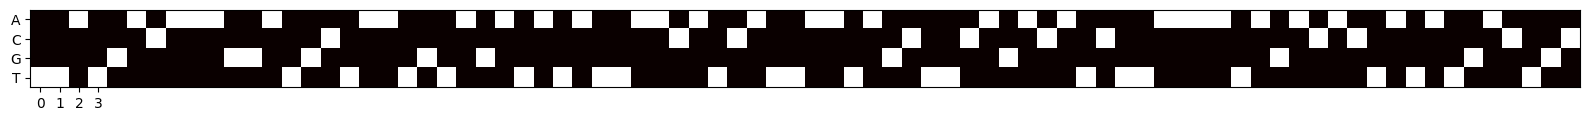

In [14]:
def print_one_hot_encoded_dna(genome_seq):
    # Plot the one hot encoded DNA sequence
    plt.figure(figsize=(20, 2))
    plt.imshow(genome_seq, cmap="hot")
    plt.xticks(range(0, genome_seq.shape[0]))
    plt.yticks(range(0, 4), ["A", "C", "G", "T"])
    plt.show()


test_print = one_hot_encote_dna(df_train.iloc[0].genome_sequence).transpose(1, 0)
print_one_hot_encoded_dna(test_print)

DNA shape:  torch.Size([32, 4, 80])
Label shape:  torch.Size([32])
Label:  tensor([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.])
DNA:  tensor([[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0

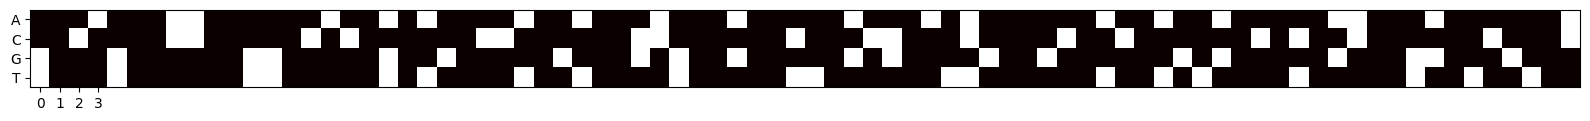

In [15]:
dataset = GenomeDatasetCNN(df_train)
dataloader = DataLoader(dataset, batch_size=32)

# print an example of the dataset
dna, label = next(iter(dataloader))
print("DNA shape: ", dna.shape)
print("Label shape: ", label.shape)
print("Label: ", label)
print("DNA: ", dna[0])
print_one_hot_encoded_dna(dna[0])  # Print the first DNA sequence of the batch

# Make our test and train datasets and data loaders
train_dataset = GenomeDatasetCNN(df_train)
test_dataset = GenomeDatasetCNN(df_test)
train_dataloader = DataLoader(
    train_dataset, batch_size=256, shuffle=True, drop_last=True
)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

## CNN

In [16]:
import torchvision.models as models
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Define the model


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        """
        # In channel: 4
        # Use 3 layers of Conv1D with kernel size (2, 3, 3) and stride (0, 1, 1), and padding (0, 1, 1)
        The in channels are: (4, 16, 32)
        The out channels are: (16, 32, 64)
        # Use 1 layer of MaxPool1D with kernel size (2) and stride (2)
        # Use 2 layers of Linear with 128 and 64 neurons
        # Use 1 layer of Linear with 1 neuron
        """

        self.conv1 = nn.Conv1d(4, 16, 2, stride=1, padding=0)
        self.conv2 = nn.Conv1d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, 3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(19 * 64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batch_norm3(x)
        x = self.dropout(x)
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        # print(x.shape)
        return x


model = CNN()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
def compute_accuracy(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    for batch_idx, (genome_seq, label) in enumerate(dataloader):
        output = model(genome_seq)
        y_true.extend(label.numpy())
        y_pred.extend(output.argmax(axis=1).numpy())
    return accuracy_score(y_true, y_pred)

In [21]:
# Train the model


def train_model(
    model,
    optimizer,
    criterion,
    dataloader,
    epochs=10,
    device="cpu",
    test_dataloader=None,
):
    model.to(device)
    losses = []
    accuracies = []
    for _ in range(epochs):
        model.train()
        train_loss = 0
        train_accuracy = 0
        for batch_idx, (genome_seq, label) in tqdm(
            enumerate(dataloader), total=len(dataloader)
        ):
            optimizer.zero_grad()
            genome_seq = genome_seq.to(device)
            label = label.to(device)
            output = model(genome_seq)
            loss = criterion(output.view(-1), label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += accuracy_score(
                label.cpu().numpy(), output.argmax(axis=1).cpu().numpy()
            )

        print("Train loss: ", train_loss / len(dataloader))
        losses.append(train_loss / len(dataloader))
        print("Train accuracy: ", train_accuracy / len(dataloader))

        # Test the model
        if test_dataloader is not None:
            accuracy = compute_accuracy(model, test_dataloader)
            print("Test accuracy: ", accuracy)
            accuracies.append((accuracy, train_accuracy / len(dataloader)))

    return model, losses, accuracies

In [22]:
model = train_model(
    model,
    optimizer,
    criterion,
    train_dataloader,
    epochs=3,
    device=device,
    test_dataloader=test_dataloader,
)

100%|██████████| 3125/3125 [04:58<00:00, 10.47it/s]


Train loss:  0.6899812900161744
Train accuracy:  0.5007975
Test accuracy:  0.49898


100%|██████████| 3125/3125 [04:41<00:00, 11.09it/s]


Train loss:  0.6897934108543397
Train accuracy:  0.5007975
Test accuracy:  0.49898


100%|██████████| 3125/3125 [04:29<00:00, 11.59it/s]


Train loss:  0.689638861618042
Train accuracy:  0.5007975
Test accuracy:  0.49898


TypeError: cannot unpack non-iterable CNN object

In [ ]:
# Compute accuracy on the test set
print("Accuracy on the test set: ", compute_accuracy(model, test_dataloader))

Accuracy on the test set:  0.49898


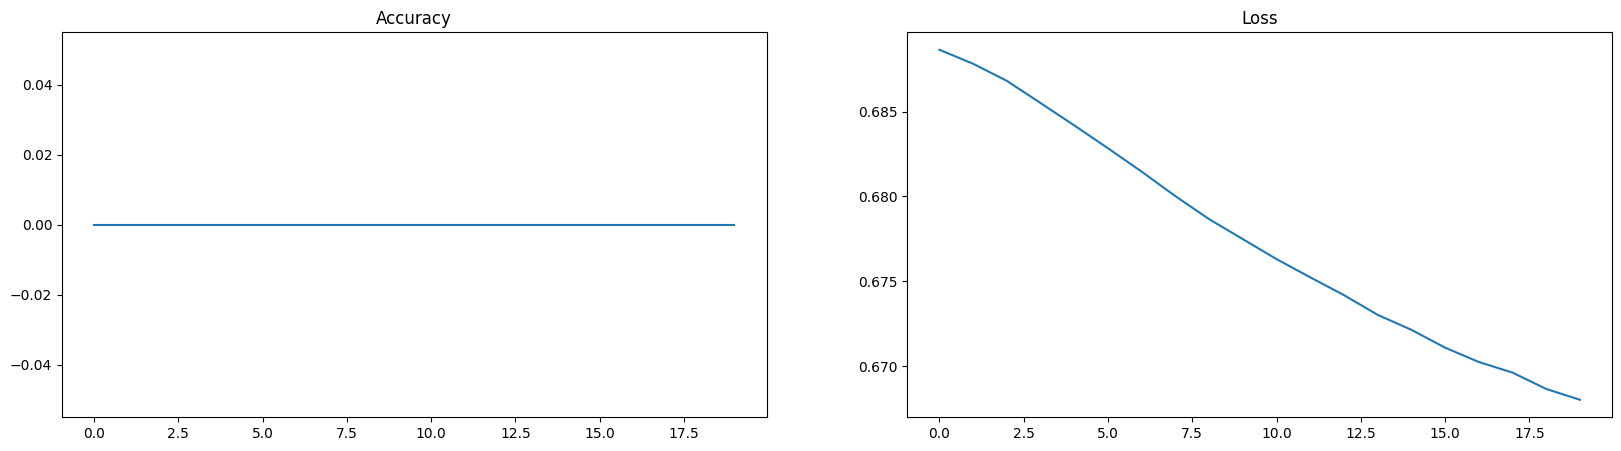

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(accuracies)
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Loss")
plt.show()